In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.3
  [780c37f4] Carlo v0.2.4
  [a93c6f00] DataFrames v1.7.0
  [f67ccb44] HDF5 v0.17.2


In [2]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using LinearAlgebra

In [3]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:J1, :K, :Lx, :Ly, :Mag, :Energy, :Dx0, :Dy0],
)

cleandata (generic function with 1 method)

In [4]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel)
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel)
    fig = Figure()
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [5]:
jobname = "parallel-test"
data = groupby(cleandata("../jobs/" * jobname * ".results.json"), [:K])

Row,J1,K,Lx,Ly,Mag,Energy,Dx0,Dy0
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…
1,-1.0,0.2,40,40,0.0044±0.00035,-2.39174±0.00016,0.44047±0.00038,0.49464±0.00065
2,-0.95,0.2,40,40,0.00639±0.00057,-2.353±0.001,0.39479±0.00059,0.46239±0.0005
3,-0.9,0.2,40,40,0.00696±0.00033,-2.3172±0.0012,0.38351±0.0003,0.43876±0.00028
4,-0.85,0.2,40,40,0.00813±0.00058,-2.27122±0.0008,0.34525±0.00055,0.40605±0.00034
5,-0.8,0.2,40,40,0.00664±0.00042,-2.24651±9.9e-5,0.317533±9.2e-5,0.36214±0.00016
6,-0.75,0.2,40,40,0.00371±0.00026,-2.20469±9.9e-5,0.30664±0.00027,0.35851±0.00032
7,-0.7,0.2,40,40,0.00344±0.00029,-2.18206±8.2e-5,0.29281±0.00018,0.31976±0.00038
8,-0.65,0.2,40,40,0.00411±0.00028,-2.13711±0.00089,0.28399±0.00054,0.3159±0.0011
9,-0.6,0.2,40,40,0.00266±0.00015,-2.1344±0.001,0.2876±0.00097,0.30453±0.00023


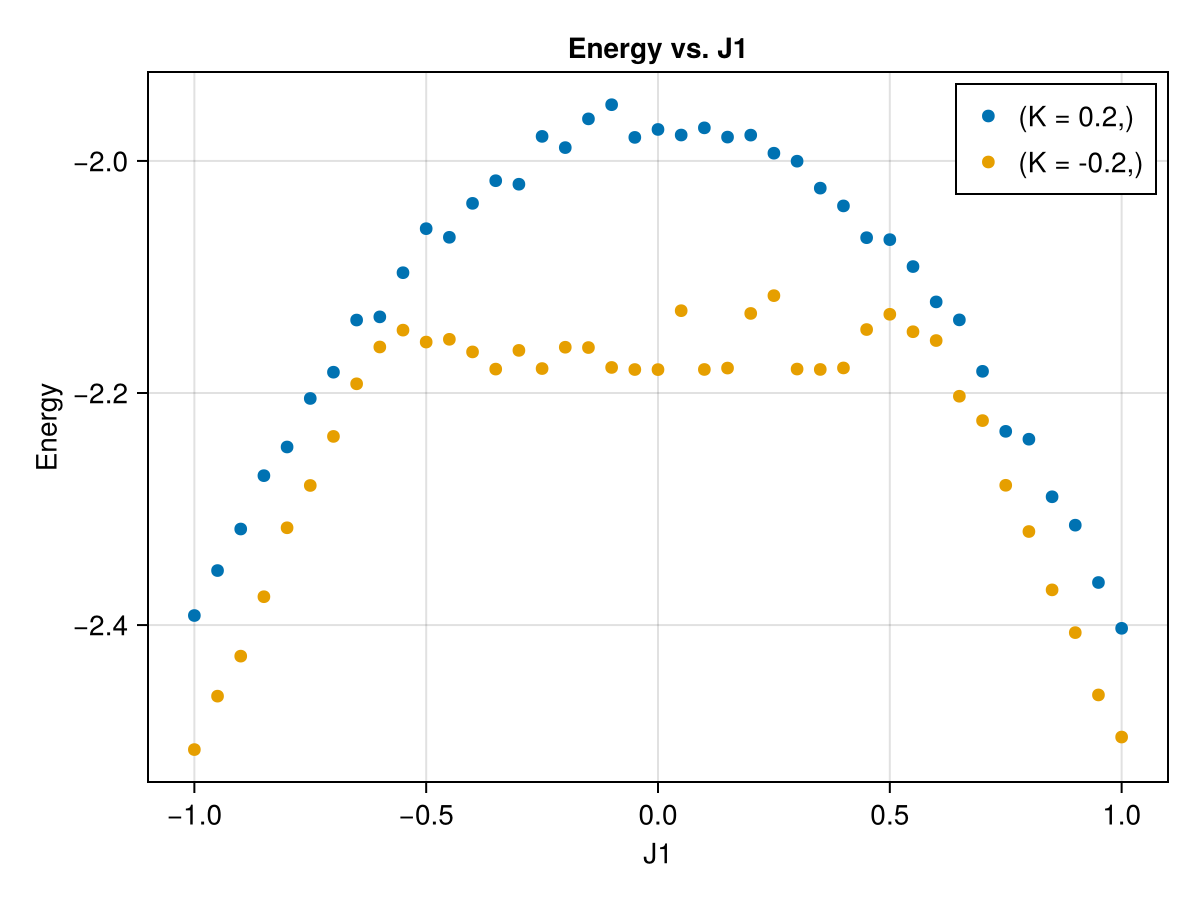

In [6]:
generatePlot(
    data, :J1, :Energy;
    title="Energy vs. J1",
    xlabel="J1",
    ylabel="Energy"
)

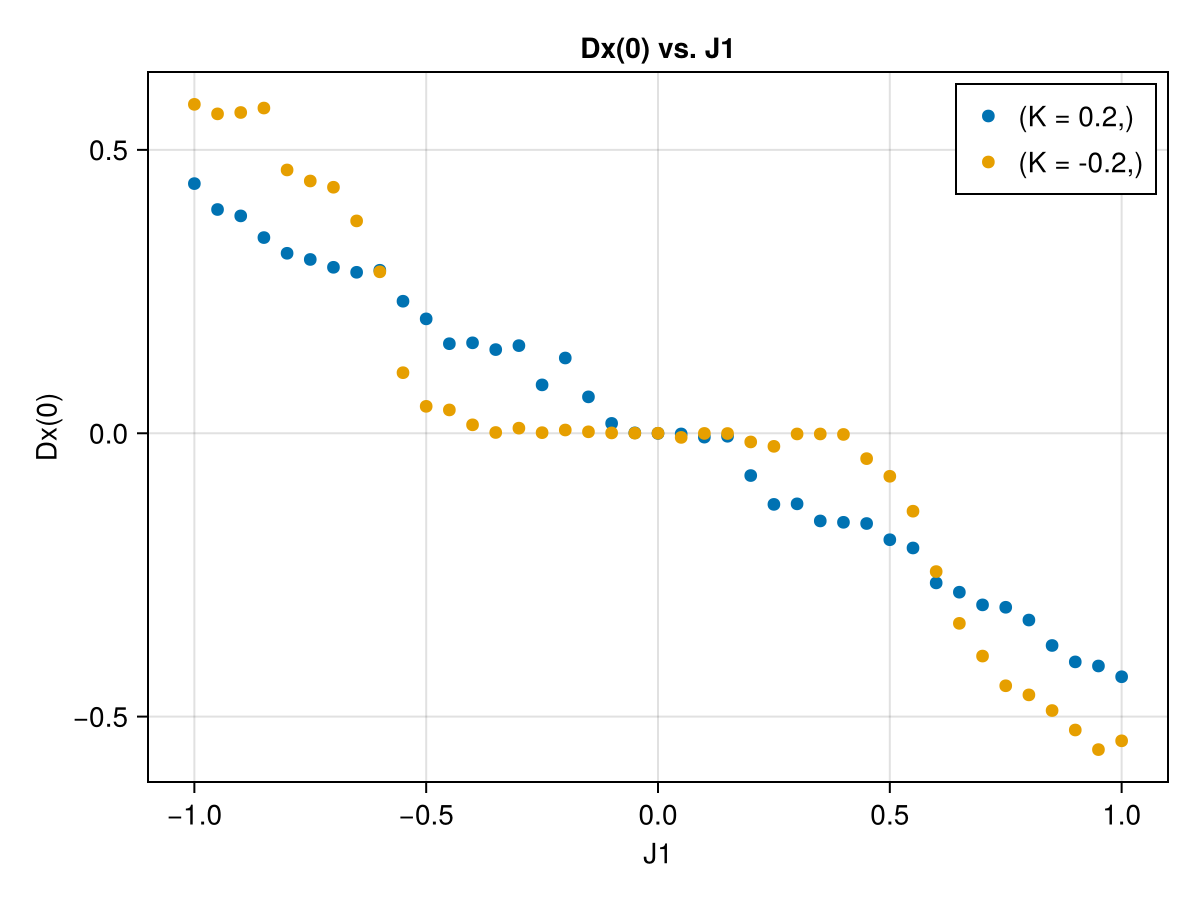

In [7]:
generatePlot(
    data, :J1, :Dx0;
    title="Dx(0) vs. J1",
    xlabel="J1",
    ylabel="Dx(0)"
)

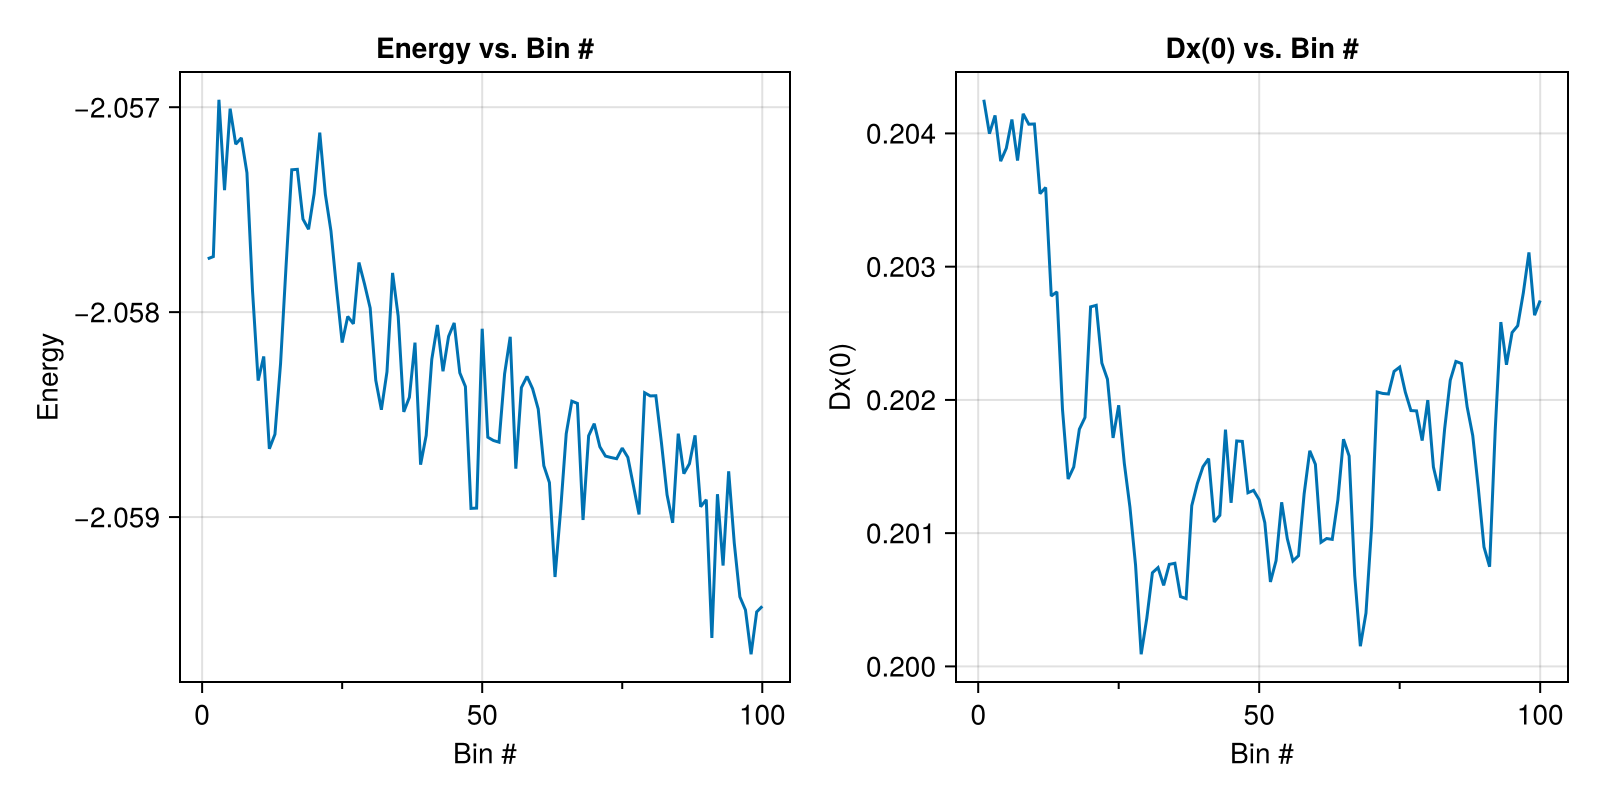

In [8]:
fig = Figure(size=(800, 400))

ax_energy = fig[1,1] = Axis(
    fig,
    title="Energy vs. Bin #",
    xlabel="Bin #",
    ylabel="Energy",
    xminorticksvisible=true
)
ax_Dx0 = fig[1,2] = Axis(
    fig,
    title="Dx(0) vs. Bin #",
    xlabel="Bin #",
    ylabel="Dx(0)",
    xminorticksvisible=true
)

task_no = "21"
h5open("../jobs/" * jobname * ".data/task00" * task_no * "/run0001.meas.h5") do file
    observables = file["observables"]
    energy_samples = read(observables, "Energy/samples")
    n = length(energy_samples)
    init = 1
    lines!(
        ax_energy,
        collect(init:n),
        energy_samples[init:n],
    )
    Dx0_samples = read(observables, "Dx0/samples")
    lines!(
        ax_Dx0,
        collect(init:n),
        Dx0_samples[init:n],
    )
end

fig

In [11]:
task_no = "42"
file = h5open("../jobs/$jobname.data/task00$task_no/run0001.dump.h5")
spins = map(
    t -> [t[:data][1], t[:data][2], t[:data][3]],
    read(file, "simulation/spins")
)
spin_xs = map(v -> v[1], spins)
spin_ys = map(v -> v[2], spins)
spin_zs = map(v -> v[3], spins)
Lx, Ly = size(spins)
close(file)

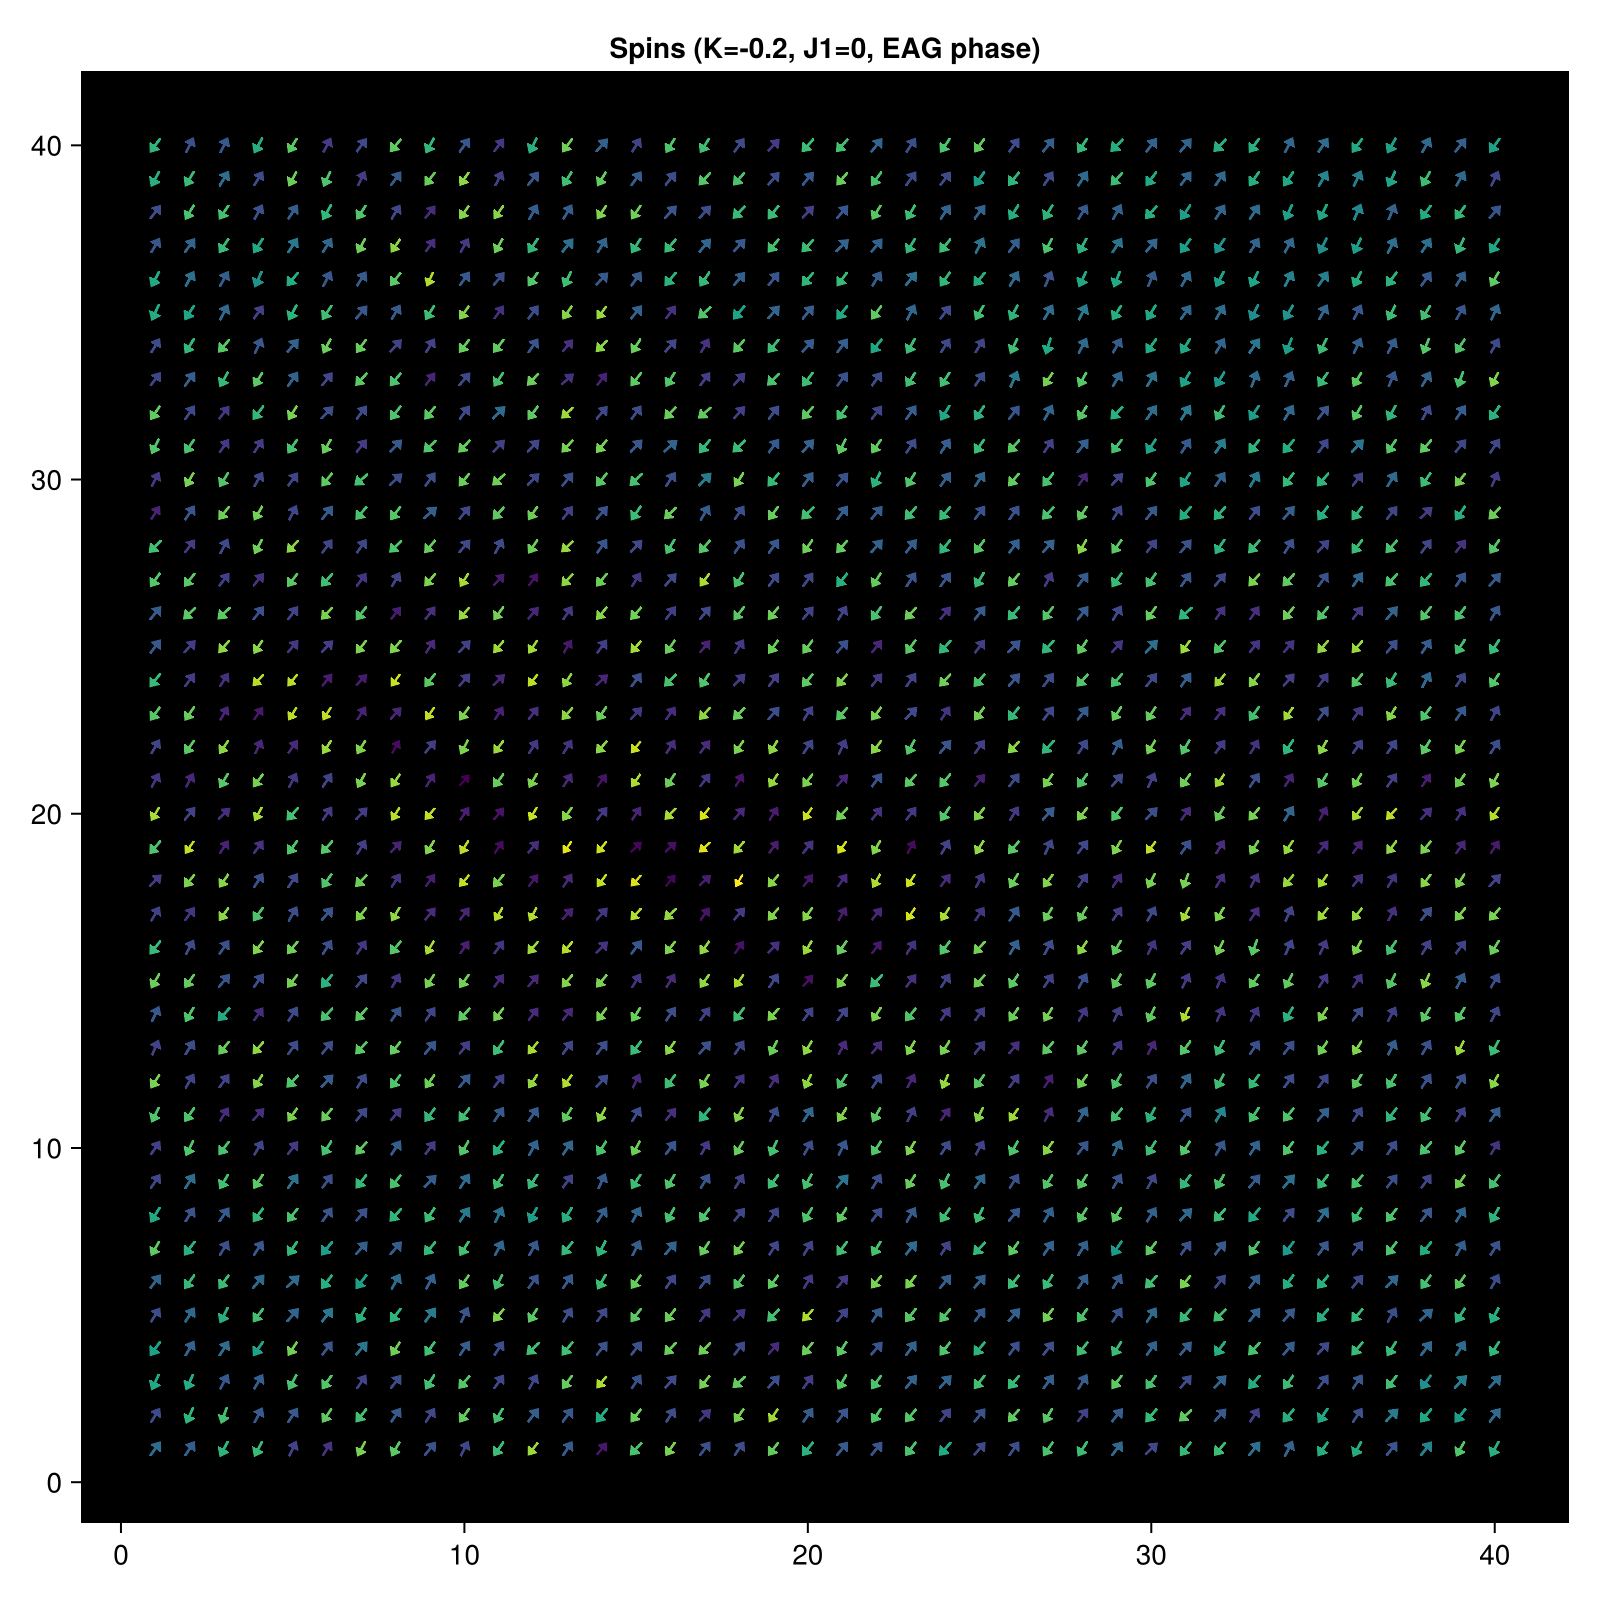

In [12]:
fig = Figure(size=(800, 800))
fig[1,1] = Axis(fig; title="Spins (K=-0.2, J1=0, EAG phase)", backgroundcolor="black")

strength = vec(spin_zs)
arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength)
fig